# Advanced usage of _DearEIS_

_DearEIS_ is primarily intended to be used via the graphical user interface (GUI).
However, it is also possible to make use of _DearEIS_ projects that have been created via the GUI in e.g. Python scripts or Jupyter notebooks.
This enables a workflow where the data is first processed using the GUI and then batch processed into publication-ready tables and figures using Python scripts:
- GUI
    - Validate experimental data
    - Fit equivalent circuits
    - Assemble plots containing multiple results
- Python script
    - Generate LaTeX tables, circuit diagrams, and math equations
    - Generate plots using e.g. `matplotlib`


## Setup in Jupyter

Below is a an example of how one might prepare a Jupyter notebook to make use of _DearEIS_.

In [1]:
# This imports classes like Project, DataSet, FitResult, etc.
from deareis import *

# This imports functions that can be used to plot instances of e.g. DataSet. Most of the functions are from the pyimpspec.plot.mpl module.
from deareis.plot.mpl import *

In [2]:
# This is just an example of how to prepare the Jupyter notebook for plotting and is not strictly necessary.
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = [12, 6]
from matplotlib.figure import Figure
from typing import List, Optional

## Loading a project

Projects can be loaded using the `from_file` method.

In [3]:
path: str = "./example-project.json"
project: Project = Project.from_file(path)

## Plotting various parts of a project

The `Project` class has methods for getting the data sets, Kramers-Kronig test results, equivalent circuit fitting results, and simulated spectra.
The easiest way to plot these are by using _pyimpspec_'s plotting functions.
However, the various objects do have methods such as `get_nyquist_data` and `get_bode_data` that can be used to obtain _numpy_ arrays containing the data required to create custom plots.

### Data sets

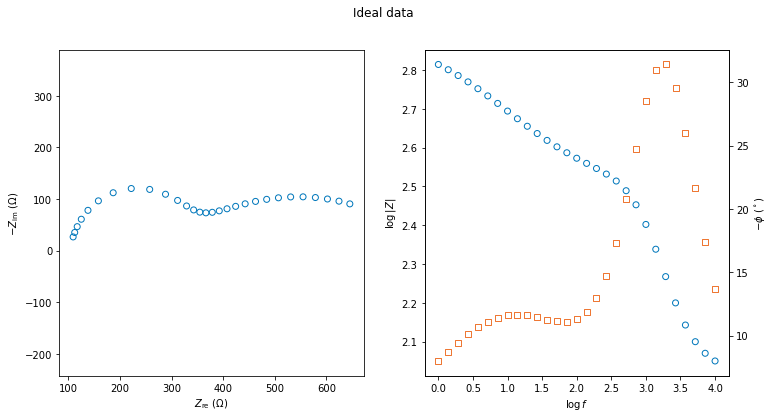

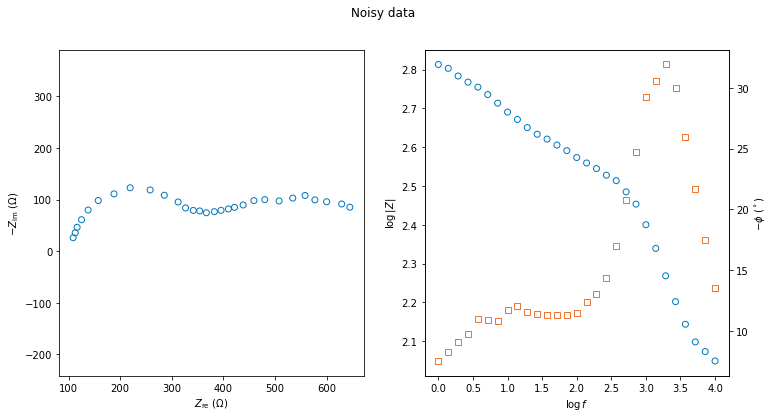

In [4]:
data: DataSet
for data in project.get_data_sets():
    fig, axes = plot_data(data)

### Kramers-Kronig test results

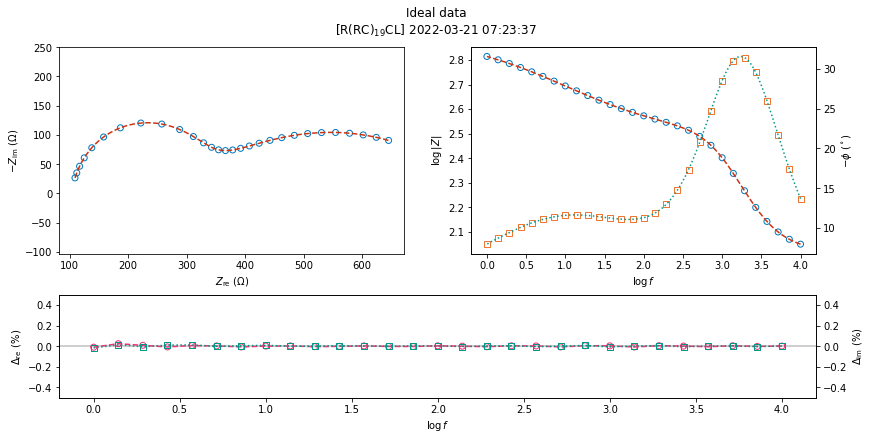

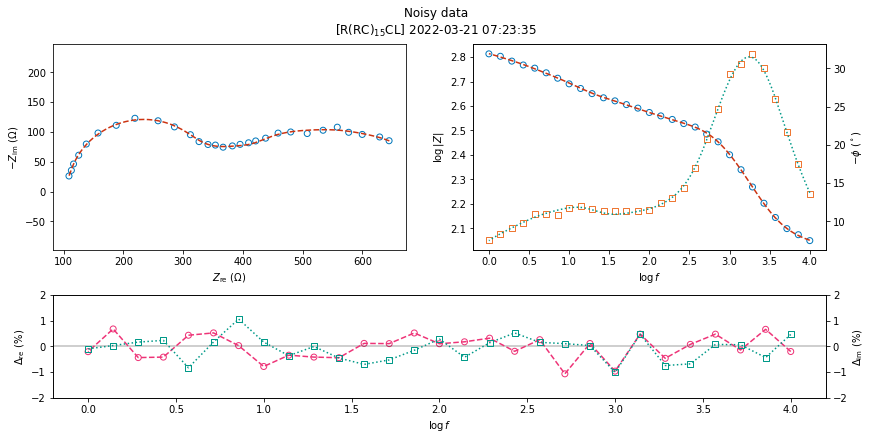

In [5]:
data: DataSet
for data in project.get_data_sets():
    test: TestResult
    for test in project.get_tests(data):
        fig, axes = plot_fit(test, data)

### Fit results

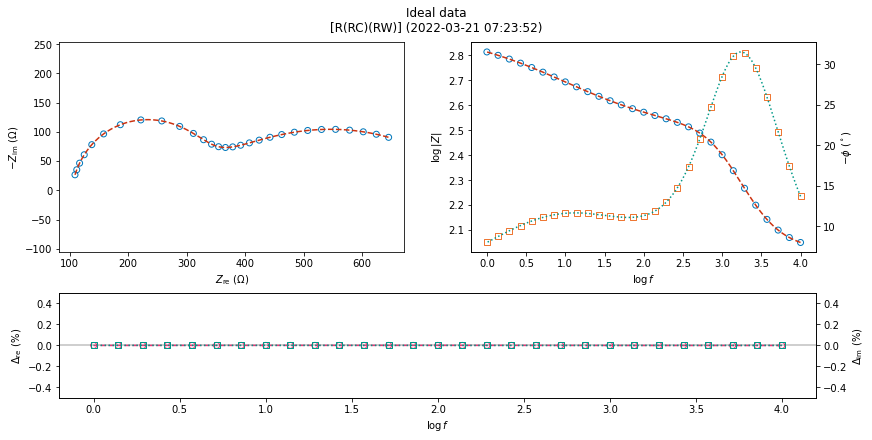

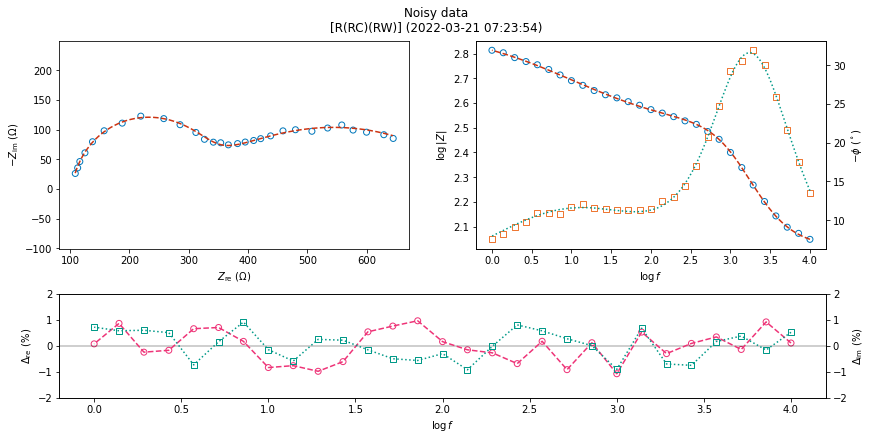

In [6]:
data: DataSet
for data in project.get_data_sets():
    fit: FitResult
    for fit in project.get_fits(data):
        fig, axes = plot_fit(fit, data)

### Simulation results

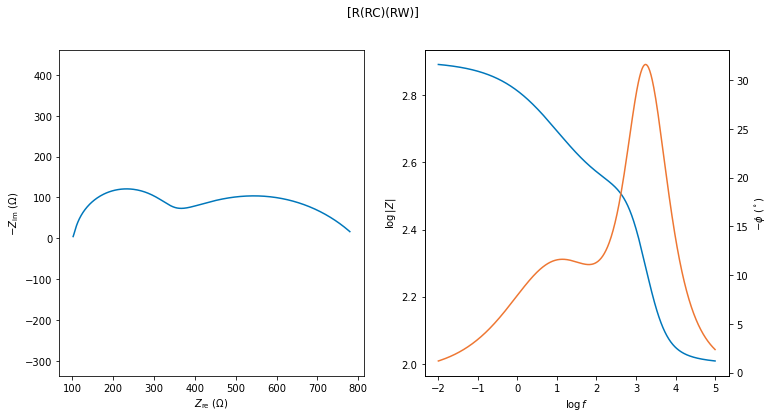

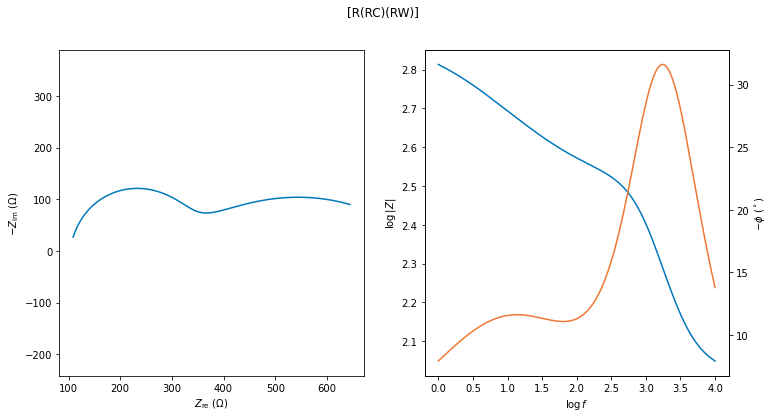

In [7]:
sim: SimulationResult
for sim in project.get_simulations():
    fig, axes = plot_circuit(sim.circuit, sim.get_frequency(num_per_decade=100))

### Plot settings

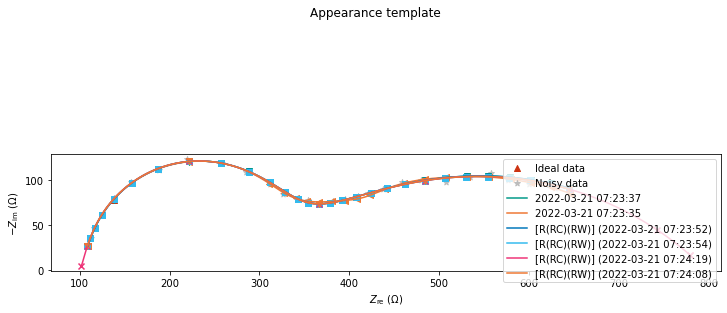

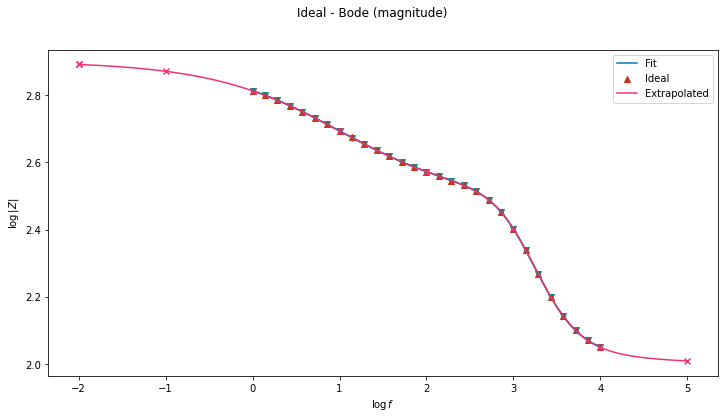

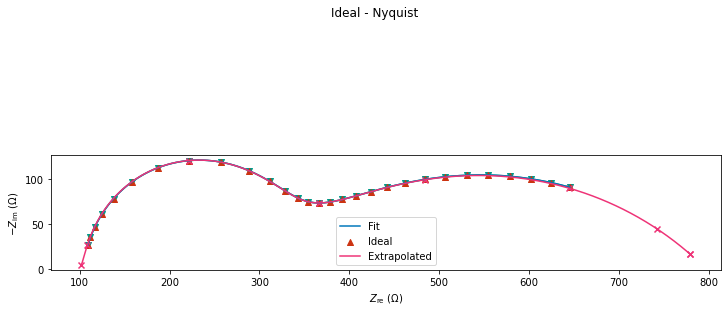

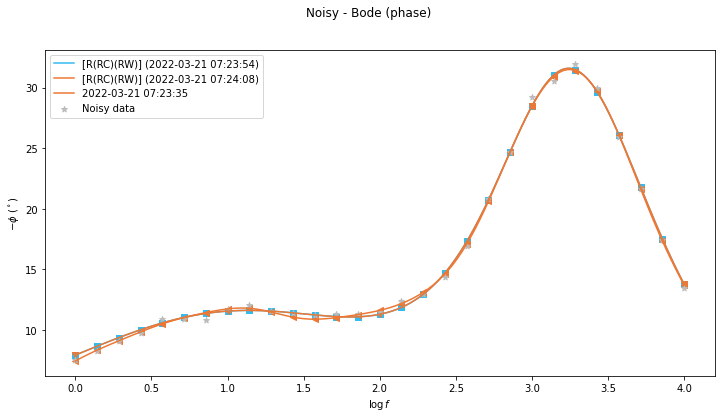

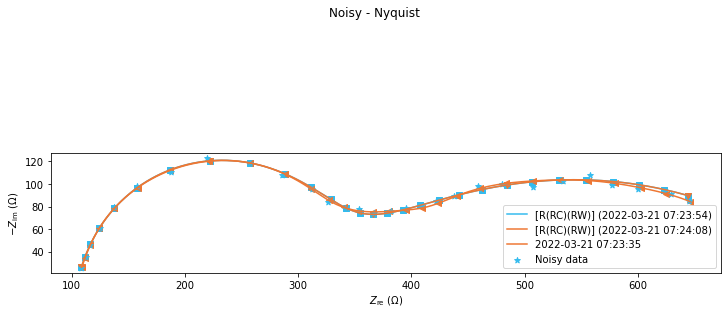

In [8]:
settings: PlotSettings
for settings in project.get_plots():
    fig, axis = plot(settings, project)

### Custom plots

You can also plot the various data series yourself.
The `from deareis.plot.mpl import *` at the beginning of the notebook also imports a dictionary called `MPL_MARKERS` that can be used to look up matplotlib's equivalent string representation for similar markers.
If you are using a plotting library that is not currently supported, then you can compare the return value of `series.get_marker()` against _DearPyGui_'s `mvPlotMarker_*` constants and figure out the appropriate value for your plotting library of choice.

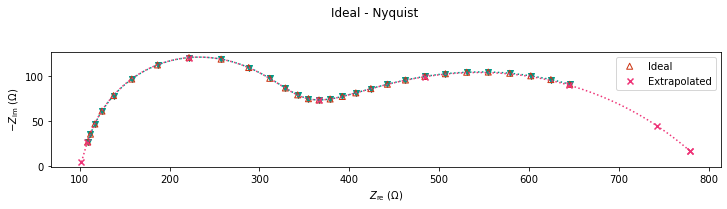

In [9]:
fig = Figure(figsize=(12,3))
ax = fig.gca()
settings = list(filter(lambda s: s.get_label() == "Ideal - Nyquist", project.get_plots()))[0]
series: PlotSeries
for series in project.get_plot_series(settings, num_per_decade=50):
    label: Optional[str] = None
    if series.has_legend():
        label = series.get_label()
    color: List[float] = series.get_color()
    marker: Optional[str] = MPL_MARKERS.get(series.get_marker())
    if series.has_line():
        ax.plot(*series.get_line_data(), color=color, linestyle=":", label=label if marker is None else None)
        if marker is not None:
            ax.scatter(*series.get_scatter_data(), color=color, marker=marker, label=label)
    elif marker is not None:
        ax.scatter(*series.get_scatter_data(), edgecolor=color, facecolor="None", marker=marker, label=label)
fig.suptitle(settings.get_label())
ax.legend()
ax.set_aspect("equal")
ax.set_xlabel(r"$Z_{\rm re}\ (\Omega)$")
ax.set_ylabel(r"$-Z_{\rm im}\ (\Omega)$")
fig

## Generating text output

### Tables

`FitResult` and `SimulationResult` objects have a `to_dataframe` method that returns a `pandas.DataFrame` object, which can be used to generate circuit element parameter tables in various formats.

In [10]:
for data in project.get_data_sets():
    for fit in project.get_fits(data):
        print(f"<!-- {fit.get_label()} - Markdown -->")
        print(fit.to_dataframe().to_markdown(index=False, floatfmt=".3g"))
        print(f"\n% {fit.get_label()} - LaTeX")
        print(fit.to_dataframe().to_latex(index=False))
        print("\n")
        break
    break

for sim in project.get_simulations():
    print(f"<!-- {sim.get_label()} - Markdown -->")
    print(sim.to_dataframe().to_markdown(index=False, floatfmt=".3g"))
    print(f"\n% {sim.get_label()} - LaTeX")
    print(sim.to_dataframe().to_latex(index=False))
    print("\n")
    break

<!-- [R(RC)(RW)] (2022-03-21 07:23:52) - Markdown -->
| Element   | Parameter   |    Value | Std. err. (%)   | Fixed   |
|:----------|:------------|---------:|:----------------|:--------|
| C_2       | C           |   8e-07  | -               | No      |
| R_0       | R           | 100      | -               | No      |
| R_1       | R           | 200      | -               | No      |
| R_3       | R           | 500      | -               | No      |
| W_4       | Y           |   0.0004 | -               | No      |

% [R(RC)(RW)] (2022-03-21 07:23:52) - LaTeX
\begin{tabular}{llrll}
\toprule
Element & Parameter &        Value & Std. err. (\%) & Fixed \\
\midrule
    C\_2 &         C & 7.999950e-07 &             - &    No \\
    R\_0 &         R & 1.000009e+02 &             - &    No \\
    R\_1 &         R & 1.999982e+02 &             - &    No \\
    R\_3 &         R & 5.000095e+02 &             - &    No \\
    W\_4 &         Y & 4.000012e-04 &             - &    No \\
\bottomrule
\

Custom tables could be generated by first obtaining e.g. the frequencies (`fit.get_frequency()`) and impedances (`fit.get_impedance()`).
A `pandas.DataFrame` object could then be generated from a Python dictionary using the `pandas.DataFrame.from_dict()` method and subsequently used to obtain tables in various formats.

### Equations and circuit diagrams

Each `FitResult` and `SimulationResult` object contains a `pyimpspec.Circuit` object that can be used to output _SymPy_ expressions, LaTeX math equations, and LaTeX macros for drawing circuit diagrams (requires the `circuitikz` LaTeX package).

In [11]:
for data in project.get_data_sets():
    for fit in project.get_fits(data):
        print("# SymPy expression")
        print(fit.circuit.to_sympy())
        print("\n% LaTeX math equation")
        print(fit.circuit.to_latex())
        print("\n% LaTeX circuit diagram")
        print(fit.circuit.to_circuitikz())
        break
    break

# SymPy expression
R_0 + 1/(2*I*pi*C_2*f + 1/R_1) + 1/(sqrt(2)*sqrt(pi)*Y_4*sqrt(I*f) + 1/R_3)

% LaTeX math equation
R_{0} + \frac{1}{2 i \pi C_{2} f + \frac{1}{R_{1}}} + \frac{1}{\sqrt{2} \sqrt{\pi} Y_{4} \sqrt{i f} + \frac{1}{R_{3}}}

% LaTeX circuit diagram
\begin{circuitikz}
	\draw (0,0) node[above]{WE+WS} to[short, o-] (1,0);
	\draw (1.0,0.0) to[R=$R_{\rm 0}$] (3.0,0.0);
	\draw (3.0,-0.0) to[R=$R_{\rm 1}$] (5.0,-0.0);
	\draw (3.0,-1.5) to[capacitor=$C_{\rm 2}$] (5.0,-1.5);
	\draw (3.0,-0.0) to[short] (3.0,-1.5);
	\draw (5.0,-0.0) to[short] (5.0,-1.5);
	\draw (5.0,-0.0) to[R=$R_{\rm 3}$] (7.0,-0.0);
	\draw (5.0,-1.5) to[generic=$W_{\rm 4}$] (7.0,-1.5);
	\draw (5.0,-0.0) to[short] (5.0,-1.5);
	\draw (7.0,-0.0) to[short] (7.0,-1.5);
	\draw (7.0,0) to[short, -o] (8.0,0) node[above]{CE+RE};
\end{circuitikz}
